In [19]:
!install romodel

usage: install [-bCcpSsv] [-B suffix] [-f flags] [-g group] [-m mode]
               [-o owner] file1 file2
       install [-bCcpSsv] [-B suffix] [-f flags] [-g group] [-m mode]
               [-o owner] file1 ... fileN directory
       install -d [-v] [-g group] [-m mode] [-o owner] directory ...


In [21]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import math
import random
import pandas as pd
import seaborn as sns
from __future__ import division
import time
from distutils.log import error
import errno
from datetime import date
import pyomo.environ as pyo
import parameters
from pyomo.environ import *
%matplotlib inline

import sys, os
from IPython.display import display
# from romodel import UncSet, UncParam


In [ ]:
def solar(lat,lon,TimeZone):
    
    if TimeZone == 'Eastern':
        LocalMeridian = 75
    elif (TimeZone == 'Central'):
        LocalMeridian = 90
    elif (TimeZone == 'Mountain'):
        LocalMeridian = 105
    elif (TimeZone == 'Pacific'):
        LocalMeridian = 120
        
    JulianDay = np.arange(1,3,1)
    LonCor = np.zeros(len(JulianDay))
    Eq_Time = np.zeros(len(JulianDay))
    SolarNoon = np.zeros(len(JulianDay))
    ApparentSolar = np.zeros(len(JulianDay))
    SolarDec = np.zeros(len(JulianDay))
    OpticalDepth = np.zeros(len(JulianDay))
    SkyDiff = np.zeros(len(JulianDay))
    SolarAltNoon = np.zeros(len(JulianDay))
    AMRNoon = np.zeros(len(JulianDay))
    
    for i in range(len(JulianDay)):
        LonCor[i] = (360/364*(JulianDay-81))
        Eq_Time[i] =(9.87*np.sin(np.radians(2*LonCor[i])))-(7.53*np.cos(np.radians(LonCor[i])))-(1.5*np.sin(np.radians(LonCor[i])))
        SolarNoon[i] = ((12*60)-4*(LocalMeridian-lon)-Eq_Time[i])/60 + 1
        ApparentSolar[i] = 1160+75*np.sin(np.radians((360/365)*(JulianDay[i]-275)))
        SolarDec[i] = 23.45*np.sin(np.radians(360/365*(JulianDay[i]-81)))
   
    for i in range(len(JulianDay)):
        OpticalDepth[i] = 0.174+0.035*np.sin(np.radians(360/365*(JulianDay[i]-100)))
        SkyDiff[i] = 0.095 + 0.04*np.sin(np.radians(360/365*(JulianDay[i]-100)))
        SolarAltNoon[i] = np.degrees(np.arcsin(np.cos(np.radians(lat))*np.cos(np.radians(SolarDec[i]))+np.sin(np.radians(lat))*np.sin(np.radians(SolarDec[i]))))
        AMRNoon[i] = abs(1/np.sin(np.radians(SolarAltNoon[i])))
    
#     Time = np.linspace(0,24,24*4)
#     SolarTime = np.zeros((len(Time),len(JulianDay)))
#     HoursAfterNoon = np.zeros((len(Time),len(JulianDay)))
#     SolarAlt = np.zeros((len(Time),len(JulianDay)))
#     AMR = np.zeros((len(Time),len(JulianDay)))
#     ClearSky = np.zeros((len(Time),len(JulianDay)))
#     Angle = np.zeros((len(Time),len(JulianDay)))
#     Irradiance = np.zeros((len(Time),len(JulianDay)))
    
#     for i in range(len(JulianDay)):
#         for j in range(len(Time)):
#             SolarTime[j,i] = ((Time[j]*60+4*np.radians(LocalMeridian-lon)+Eq_Time[i])/60)-1
#             HoursAfterNoon[j,i] = SolarNoon - Time[j]
#             SolarAlt[j,i] = np.degrees(np.arcsin(np.cos(np.radians(lat))*np.cos(np.radians(SolarDec[i]))*np.cos(np.radians(15*HoursAfterNoon[j,i]))+np.sin(np.radians(lat))*np.sin(np.radians(SolarDec[i]))))
#             AMR[j,i] = abs(1/np.sin(np.radians(SolarAlt[j,i])))
#             if (SolarAlt[j,i] >0):
#                 ClearSky[j,i] = ApparentSolar[i]*np.exp(-OpticalDepth[i]*AMR[j,i])
#             else:
#                 ClearSky[j,i] = 0
#             Angle[j,i] = np.sin(np.radians(SolarAlt[j,i]))
#             Irradiance[j,i] = ClearSky[j,i]*(Angle[j,i]+SkyDiff[i])
                                          
    
    
    return JulianDay


solar(51,122.272743,'Pacific')
    
    
    
    
    
    
    

ERROR! Session/line number was not unique in database. History logging moved to new session 241


In [25]:
User_PV_Data = pd.read_csv('./Austin_15_661_January.csv')

# get_all_values gives a list of rows.


userdata = np.array(User_PV_Data.values)


print(User_PV_Data)


       dataid  local_15min  battery1   grid  solar  solar2  \
0       661.0  1/1/18 0:00       NaN    NaN    NaN     NaN   
1       661.0  1/1/18 0:15       NaN    NaN    NaN     NaN   
2       661.0  1/1/18 0:30       NaN    NaN    NaN     NaN   
3       661.0  1/1/18 0:45       NaN    NaN    NaN     NaN   
4       661.0  1/1/18 1:00       NaN  1.447 -0.002     NaN   
...       ...          ...       ...    ...    ...     ...   
35035     NaN          NaN       NaN    NaN    NaN     NaN   
35036     NaN          NaN       NaN    NaN    NaN     NaN   
35037     NaN          NaN       NaN    NaN    NaN     NaN   
35038     NaN          NaN       NaN    NaN    NaN     NaN   
35039     NaN          NaN       NaN    NaN    NaN     NaN   

       Whole Home Use (kW)  kwh-1panel-15min  
0                    0.000               0.0  
1                    0.000               0.0  
2                    0.000               0.0  
3                    0.000               0.0  
4                   

In [45]:
prof=pd.Series(dtype='object')

prof.loc['Time']=User_PV_Data.iloc[:2976,1]
prof.loc['Solar']=User_PV_Data.iloc[:2976, 7]*.25 #convert to kWh
prof.loc['Load']=User_PV_Data.iloc[:2976, 6]*.25#convert to kWh 
# prof.loc['Price']=User_PV_Data.iloc[:, 4]

type(prof.Load[2975])

numpy.float64

In [74]:
def microgrid(Nbmax,Npmax):
    
    m = ConcreteModel()
    
    # Time
    T = np.shape(prof.Time)[0]
    m.k = RangeSet(0,T-1)
    
    # Scalar Parameters
    m.Cgi = Param(initialize=0.1990) #average cost of electricity in California ($/kWh)
    m.Cs = Param(initialize=0.08) #average cost of solar in US ($/kWh)
    m.Cb = Param(initialize=20) #predicted cost of battery in 2022 ($/kWh)
    m.Cge = Param(initialize=0.03) #PGE average sell to grid rate ($/kWh)
    m.eta_b = Param(initialize=0.85) #discharging efficiency
    m.r = Param(initialize=0.004) # Real interest rate
    m.MaxPanels = Param(initialize=Npmax//1.6) #Max Allowed Solar Panels (m2/m2)
    m.SolarEng = Param(initialize=1.5)
    
    
    # Indexed Parameters
    m.Solar = Param(m.k,initialize=dict(enumerate(prof.Solar,0)))
    m.Load = Param(m.k,initialize=dict(enumerate(prof.Load,0)))
   
    # Variables
    m.Np = Var(within=PositiveReals,bounds = (0,m.MaxPanels),initialize=m.MaxPanels) #Number of Panels
    m.Nb = Var(within=PositiveReals,bounds=(0,Nbmax),initialize=Nbmax) #Battery Capacity (kWh)
    m.SOC = Var(m.k, within=NonNegativeReals, bounds=(0,Nbmax),initialize=Nbmax) #Battery SOC (kWh)
    m.Bc = Var(m.k, within=NonNegativeReals, initialize=0) #Battery Charge (kWh)
    m.Bd = Var(m.k, within=NonNegativeReals,initialize=0) #Batttery Discharge (kWh)
    m.Ge = Var(m.k, within=NonNegativeReals, initialize=0) #Sell to grid (kWh)
    m.Gi = Var(m.k, within=NonNegativeReals,initialize = 0)  #Take from grid (kWh)
    m.C = Var(m.k, within=NonNegativeReals,initialize=m.Load[0]) #Supplied to Demand (kWh)
    m.S = Var(m.k,within=NonNegativeReals, initialize=0) #Actual Solar Supplied to System (kWh)
    
    #Objective
    def ObjF(m):
        return m.Cs*m.Np*m.SolarEng + m.Cb*m.Nb + sum(m.Cgi*m.Gi[k] - m.Cge*m.Ge[k] for k in m.k)
    m.Cost = Objective(rule=ObjF)

    #Constraints
    def TotalBalance(m,k):
        return (m.S[k] + m.Gi[k] + m.Bd[k] == m.Ge[k] + m.Bc[k] + m.C[k])
    m.TotalBalance = Constraint(m.k,rule=TotalBalance)
    
    def SolarBalance(m,k):
        return (m.Solar[k]*m.Np == m.S[k])
    m.SolarBalance = Constraint(m.k,rule=SolarBalance)
    
    def SOClower(m,k):
        m.SOC[0] == m.Nb
        return (0,m.SOC[k],None)
    m.SOClower = Constraint(m.k,rule=SOClower)
    
    def SOCupper(m,k):
        m.SOC[0] == m.Nb
        return (None, m.SOC[k]-m.Nb,0)
    m.SOCupper = Constraint(m.k,rule=SOCupper)
    
    def SOCBalance(m,k):
        m.SOC[0] == m.Nb
        if k<=T-2:
            return (m.SOC[k+1] == m.SOC[k] + m.eta_b*m.Bc[k] - m.Bd[k]/m.eta_b)
        else:
            return (m.SOC[k]== m.SOC[k] + m.eta_b*m.Bc[k] - m.Bd[k]/m.eta_b)
    m.SOCBalance = Constraint(m.k,rule=SOCBalance)

    def DeltaB(m,k):
        if k<T-2:
            return (None,m.SOC[k+1]-m.SOC[k]-(m.Nb/4),0)
        else:
            return (None,m.SOC[k]-(m.Nb/4),0)
    m.DeltaB = Constraint(m.k,rule=DeltaB)
    
    def Discharge(m,k):
        return (None,m.eta_b*m.Bd[k]-m.SOC[k],0)
    m.Discharge = Constraint(m.k,rule=Discharge)
    
    def Charge(m,k):
        return (None,m.Bc[k]+m.SOC[k]-m.Nb,0)
    m.Charge = Constraint(m.k,rule=Charge)

    def TakeGridBalance(m,k):
        return (0,m.Gi[k],m.Load[k])
    m.TakeGridBalance = Constraint(m.k,rule=TakeGridBalance)
    
    def GiveGridBalanceLower(m,k):
        return (0,m.Ge[k],None)
    m.GiveGridBalanceLower = Constraint(m.k,rule=GiveGridBalanceLower)
    
    def GiveGridBalanceUpper(m,k):
        return (None,m.Ge[k]-m.Load[k]-m.Bc[k],0)
    m.GiveGridBalanceUpper = Constraint(m.k,rule=GiveGridBalanceUpper)
    
    def LoadBalance(m,k):
#         return (m.Load[k], m.C[k], None) # Can be changed to adapt
        return m.Load[k] == m.C[k]
    m.LoadBalance = Constraint(m.k,rule=LoadBalance)
    
    
    #Solve
    solver = SolverFactory('glpk')
    results = solver.solve(m)
    
# Final Values
    Time = np.zeros((T,1))
    Time = np.arange(0,T,1)
    Load = np.zeros((T,1))
    Price = np.zeros((T,1))
    Solar_Obtained = np.zeros((T,1))
    SOC = np.zeros((T,1))
    Bc = np.zeros((T,1))
    Bd = np.zeros((T,1))
    Gi = np.zeros((T,1))
    Ge = np.zeros((T,1))
    C = np.zeros((T,1))
    
    for k in range(len(m.k)):
        Load[k] = value(m.Load[k])
        Price[k] = value(m.Cgi)*value(m.Gi[k])+value(m.Cs)*value(m.Np)+value(m.Cb)*value(m.Np)-value(m.Cge)*value(m.Ge[k])
        Solar_Obtained[k] = value(m.S[k])
        SOC[k] = value(m.SOC[k])
        Bc[k] = value(m.Bc[k])
        Bd[k] = value(m.Bd[k])
        Gi[k] = value(m.Gi[k])
        Ge[k] = value(m.Ge[k])
        C[k] = value(m.C[k])
    
# Plot 
    plt.figure(figsize = (15,10))
    plt.plot(Time[:960],Load[:960])
#     plt.plot(Time,C)
    plt.plot(Time[:960],Solar_Obtained[:960])
    plt.plot(Time[:960],SOC[:960])
    plt.plot(Time[:960],Gi[:960])
    plt.plot(Time[:960],Ge[:960])
    plt.legend(['Load','Solar','SOC','Gi','Ge'])

    out = pd.DataFrame(dtype='object',index=Time)
    out.loc[:,'Load'] = Load
    out.loc[:,'Price'] = Price
    out.loc[:,'Solar'] = Solar_Obtained
    out.loc[:,'SOC'] = SOC
    out.loc[:,'Bc'] = Bc
    out.loc[:,'Bd'] = Bd
    out.loc[:,'Gi'] = Gi
    out.loc[:,'Ge'] = Ge
    out = out.round(2)
    final = round(value(m.Np)),value(m.Nb)
    return out,final


(      Load    Price  Solar   SOC   Bc    Bd    Gi   Ge
 0     0.00  1113.57    0.0  0.25  0.0  0.00  0.00 -0.0
 1     0.00  1113.57    0.0  0.25  0.0  0.00  0.00  0.0
 2     0.00  1113.57    0.0  0.25  0.0  0.00  0.00  0.0
 3     0.00  1113.57    0.0  0.25  0.0  0.00  0.00  0.0
 4     0.36  1113.60    0.0  0.25  0.0  0.21  0.15  0.0
 ...    ...      ...    ...   ...  ...   ...   ...  ...
 2971  1.06  1113.78    0.0  0.00  0.0  0.00  1.06  0.0
 2972  1.02  1113.77    0.0  0.00  0.0  0.00  1.02  0.0
 2973  0.97  1113.76    0.0  0.00  0.0  0.00  0.97  0.0
 2974  0.16  1113.60    0.0  0.00  0.0  0.00  0.16  0.0
 2975  0.14  1113.60    0.0  0.00  0.0  0.00  0.14  0.0
 
 [2976 rows x 8 columns],
 (55, 0.251869028925496))

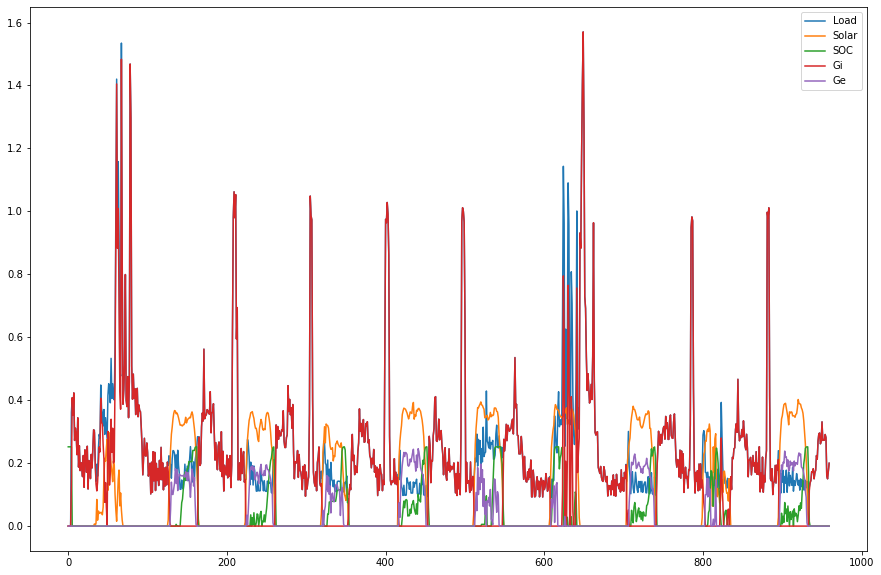

In [75]:
microgrid(2.5,1000)
# plt.plot(out[0],out[1])
 